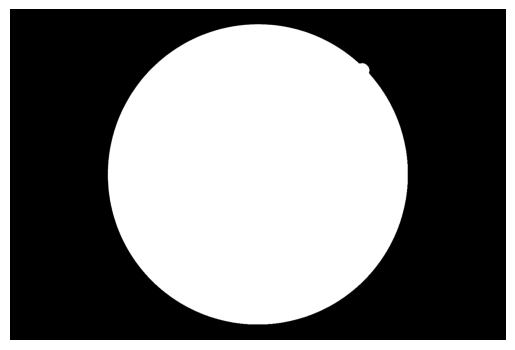

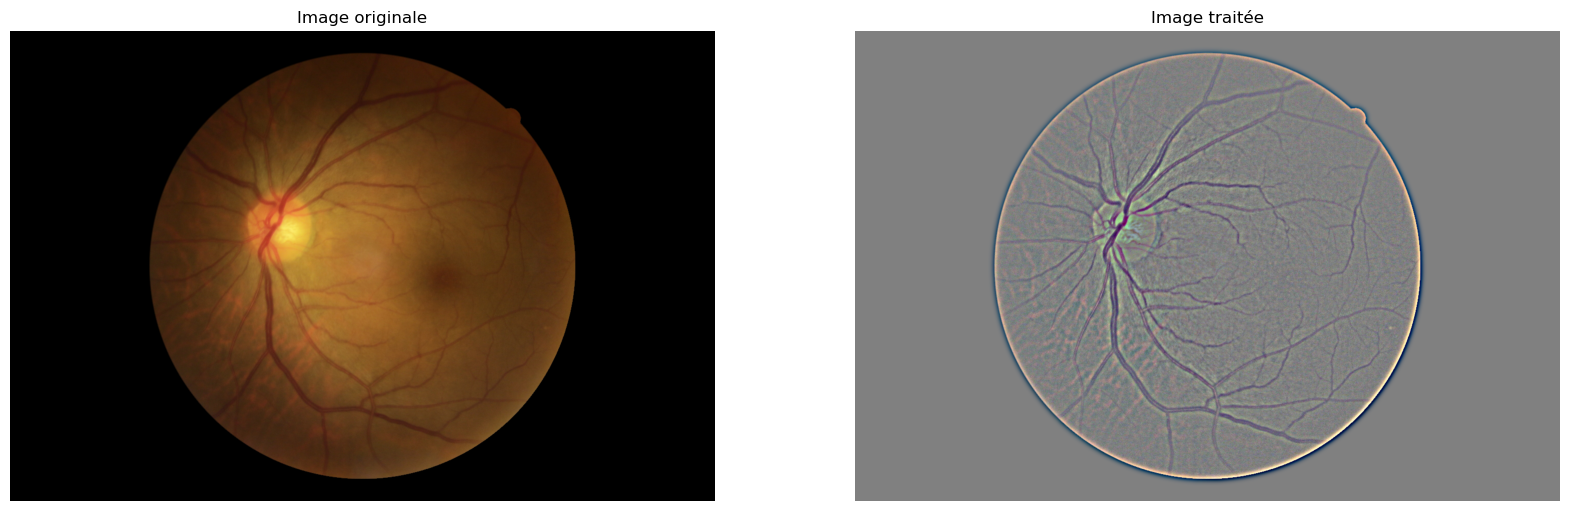

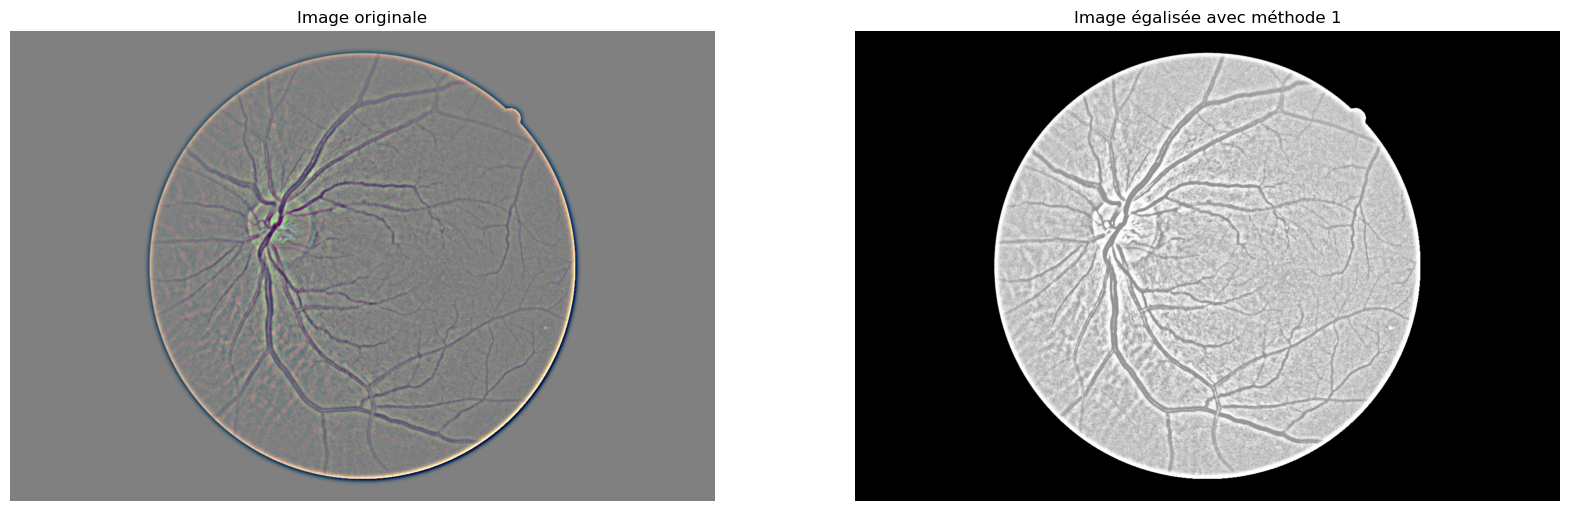

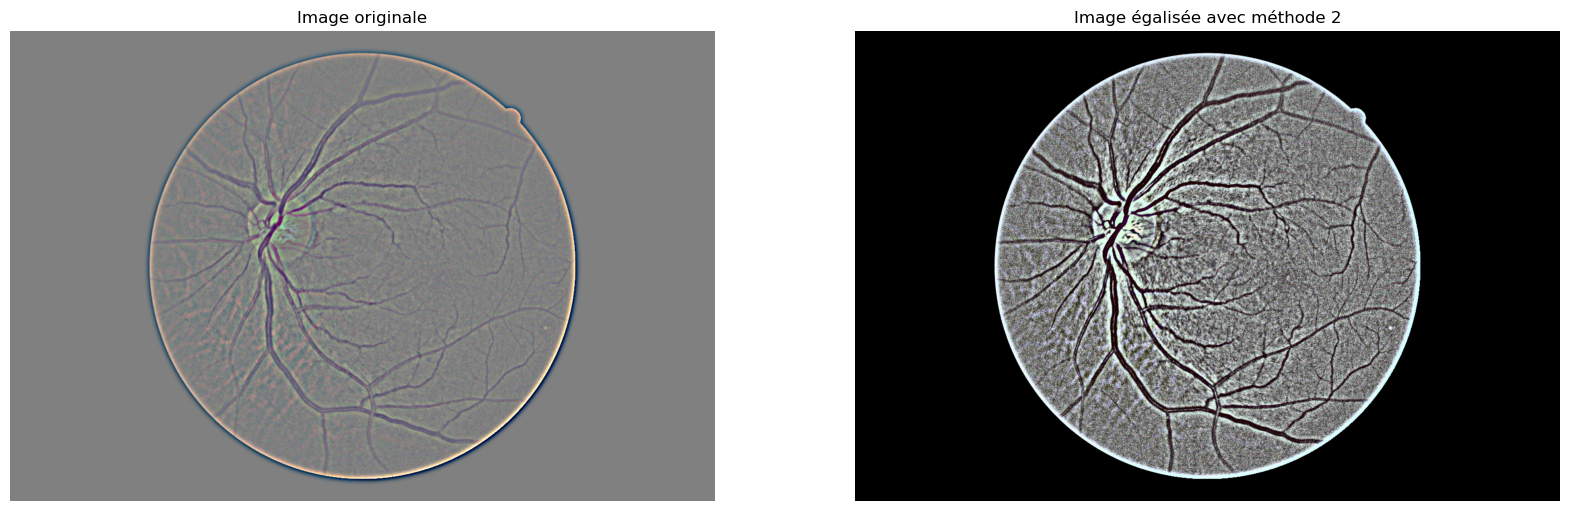

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "../data/20170310115514054.jpg"

def fundus_roi(image, mask=None):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    threshold = 15
    _, roi = cv2.threshold(v, threshold, 1, cv2.THRESH_BINARY)
    roi = roi.astype(bool)
    white_pixels = np.argwhere(roi == 1)
    if white_pixels.size == 0:
        print("Aucun pixel blanc trouvé dans le masque.")
        return {"roi": roi, "diameter": 0, "image": image}
    x_min, y_min = np.min(white_pixels, axis=0)
    x_max, y_max = np.max(white_pixels, axis=0)
    diameter_x = x_max - x_min
    diameter_y = y_max - y_min
    diameter = int(np.maximum(diameter_x, diameter_y))
    return {"roi": roi, "diameter": diameter, "image": image}

# Charger l'image et obtenir la ROI
original_image = cv2.imread(image_path)
plt.imshow(fundus_roi(original_image)['roi'], cmap='gray')
plt.axis('off') 
plt.show()


def load_ben_color(image, roi_mask):
    sigmaX = 10
    image_roi = image.copy()
    image_roi[~roi_mask] = 0  # Apply ROI mask
    image_roi = cv2.addWeighted(image_roi, 4, cv2.GaussianBlur(image_roi, (0, 0), sigmaX), -4, 128)
    return image_roi

def histogram_equalization(img, roi_mask):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_roi = gray.copy()
    gray_roi[~roi_mask] = 0  # Apply ROI mask

    cdf = np.cumsum(np.histogram(gray_roi, 1024, [0, 1024])[0])
    cdf = cdf / cdf[-1]
    
    equalized_img = np.interp(gray, np.arange(0, 1024), cdf)
    equalized_img[~roi_mask] = 0  # Apply ROI mask
    equalized_img = np.array(equalized_img * 255, dtype='uint8')
    
    return equalized_img

def histogram_equalization_METH2(img, roi_mask):
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_bgr_roi = img_bgr.copy()
    img_bgr_roi[~roi_mask] = 0  # Apply ROI mask

    ycrcb_img = cv2.cvtColor(img_bgr_roi, cv2.COLOR_BGR2YCrCb)
    ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
    
    equalized_img_bgr = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
    equalized_img_rgb = cv2.cvtColor(equalized_img_bgr, cv2.COLOR_BGR2RGB)
    
    return equalized_img_rgb

# Charger l'image et obtenir la ROI
original_image = cv2.imread(image_path)
if original_image is None:
    print(f"Erreur: Impossible de charger l'image depuis {image_path}")
else:
    roi_info = fundus_roi(original_image)
    roi_mask = roi_info['roi']

    # Appliquer les traitements sur l'image avec ROI
    processed_image_1 = load_ben_color(original_image, roi_mask)

    plt.figure(figsize=(20, 20))
    plt.subplot(121)
    plt.title("Image originale")
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.axis('off') 

    plt.subplot(122)
    plt.title("Image traitée")
    plt.imshow(cv2.cvtColor(processed_image_1, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Appliquer l'égalisation d'histogramme
    equalized_img_1 = histogram_equalization(processed_image_1, roi_mask)

    plt.figure(figsize=(20, 20))
    plt.subplot(121)
    plt.title("Image originale")
    plt.imshow(cv2.cvtColor(processed_image_1, cv2.COLOR_BGR2RGB))
    plt.axis('off') 

    plt.subplot(122)
    plt.title("Image égalisée avec méthode 1")
    plt.imshow(equalized_img_1, cmap='gray')
    plt.axis('off')
    plt.show()

    # Appliquer l'égalisation d'histogramme avec la méthode 2
    equalized_img_2 = histogram_equalization_METH2(processed_image_1, roi_mask)

    plt.figure(figsize=(20, 20))
    plt.subplot(121)
    plt.title("Image originale")
    plt.imshow(cv2.cvtColor(processed_image_1, cv2.COLOR_BGR2RGB))
    plt.axis('off') 

    plt.subplot(122)
    plt.title("Image égalisée avec méthode 2")
    plt.imshow(equalized_img_2)
    plt.axis('off')
    plt.show()
